# APTOS 2019 Diabetic Retinopathy Classification

Dataset: APTOS 2019 Blindness Detection (Extended with Validation Set)
Source: https://www.kaggle.com/datasets/mariaherrerot/aptos2019

Dataset Description:
- Training images: train_images/ with train.csv
- Validation images: valid_images/ with valid.csv (pre-split!)
- Test images: test_images/ with test.csv
- 5 classes: 0 (No DR), 1 (Mild), 2 (Moderate), 3 (Severe), 4 (Proliferative DR)
- Images captured under varying lighting conditions in rural India
- Significant class imbalance present

Analysis Objectives:
1. Compare Traditional ML (Random Forest) vs Deep Learning (CNN + Transfer Learning)
2. Conduct 3 systematic experiments per model (9 total experiments)
3. Demonstrate comprehensive preprocessing and feature engineering
4. Provide deep analysis: learning curves, confusion matrices, bias-variance analysis
5. Document all hyperparameter choices with clear justification

Model Selection:
- Traditional ML: Random Forest (chosen for feature importance interpretability)
- Deep Learning: Custom CNN (demonstrate architecture design skills)
- Transfer Learning: ResNet50 (proven performance on medical images)

# ENVIRONMENT SETUP & DEPENDENCIES


In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab - installing dependencies...")
    # Install additional packages if needed
    !pip install -q tensorflow scikit-learn pandas numpy matplotlib seaborn opencv-python-headless imbalanced-learn


Running in Google Colab - installing dependencies...


In [3]:
# Import core libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, DenseNet121, EfficientNetB3,
    MobileNetV3Small, VGG16
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)

In [5]:
# Traditional ML
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, f1_score, cohen_kappa_score
)

In [6]:
# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Visualization
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU Available: []


In [7]:
"""
Setting random seeds for reproducibility across all libraries.
This ensures experiments can be replicated exactly.
"""

SEED = 42

def set_seeds(seed=SEED):
    """Set seeds for reproducibility"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()
print(f"All random seeds set to {SEED} for reproducibility")

All random seeds set to 42 for reproducibility


# SECTION 3: DATA LOADING & EXPLORATION

Load the APTOS 2019 dataset with pre-split train/validation/test sets.
This saves preprocessing time and ensures consistent evaluation.

Key advantage of this dataset version:
- Validation set already provided → no need to manually split
- Consistent splits across all experiments


In [8]:
from google.colab import drive
from zipfile import ZipFile
import os

# Mount your Google Drive
drive.mount('/content/drive')

# Path to the ZIP file on Drive
DATA_PATH = '/content/drive/MyDrive/aptos2019'

# Directory where the contents of the zip files will be extracted
EXTRACT_PATH = './aptos2019'
os.makedirs(EXTRACT_PATH, exist_ok=True)


for file in os.listdir(DATA_PATH):
    if file.endswith('.zip'):
        zip_path = os.path.join(DATA_PATH, file)
        print(f'Extracting {file}...')
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
    if file.endswith('.csv'):
      print("Met a csv file",DATA_PATH, file)



print(f'✅ All files extracted to {EXTRACT_PATH}/')


# -----------------------------
# Paths to CSVs
# -----------------------------
TRAIN_CSV = os.path.join(DATA_PATH, 'train_1.csv')
VALID_CSV = os.path.join(DATA_PATH, 'valid.csv')
TEST_CSV  = os.path.join(DATA_PATH, 'test.csv')

# -----------------------------
# Paths to image folders (updated to the extraction path)
# -----------------------------
TRAIN_IMAGES = os.path.join(EXTRACT_PATH, 'train_images')
VALID_IMAGES   = os.path.join(EXTRACT_PATH, 'val_images')
TEST_IMAGES  = os.path.join(EXTRACT_PATH, 'test_images')

# -----------------------------
# Quick check
# -----------------------------
print("Files in dataset folder:", os.listdir(DATA_PATH))
print("Sample training images:", os.listdir(TRAIN_IMAGES)[:5])
print("Sample validation images:", os.listdir(VALID_IMAGES)[:5])
print("Sample test images:", os.listdir(TEST_IMAGES)[:5])

Mounted at /content/drive
Met a csv file /content/drive/MyDrive/aptos2019 test.csv
Met a csv file /content/drive/MyDrive/aptos2019 train_1.csv
Met a csv file /content/drive/MyDrive/aptos2019 valid.csv
Extracting test_images.zip...
Extracting val_images.zip...
Extracting train_images.zip...
✅ All files extracted to ./aptos2019/
Files in dataset folder: ['test.csv', 'train_1.csv', 'valid.csv', 'test_images.zip', 'val_images.zip', 'train_images.zip']
Sample training images: ['79059d0592c4.png', '4ef0b485a7da.png', 'a688f20f8895.png', '82910bba4753.png', 'bf1b7e21e774.png']
Sample validation images: ['0212dd31f623.png', '15b21c80cc31.png', '0afdfe5f422c.png', '0cae727cf119.png', '03fd50da928d.png']
Sample test images: ['ef7a4ed8d5d1.png', 'f3cd489acbee.png', 'eeb231c3ef1f.png', 'fb88d23fc5fe.png', 'e7578d8dba72.png']


In [9]:
print("\n" + "=" * 80)
print("LOADING DATASET")
print("=" * 80)

# Load datasets
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"\n✅ Training set: {len(train_df)} images")
print(f"✅ Validation set: {len(valid_df)} images")
print(f"✅ Test set: {len(test_df)} images")
print(f"✅ Total images: {len(train_df) + len(valid_df) + len(test_df)}")

# Display first few rows
print("\n📋 Training data sample:")
print(train_df.head())

# Check for missing values
print("\n🔍 Missing values check:")
print(f"Training: {train_df.isnull().sum().sum()} missing values")
print(f"Validation: {valid_df.isnull().sum().sum()} missing values")
print(f"Test: {test_df.isnull().sum().sum()} missing values")


LOADING DATASET

✅ Training set: 2930 images
✅ Validation set: 366 images
✅ Test set: 366 images
✅ Total images: 3662

📋 Training data sample:
        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0

🔍 Missing values check:
Training: 0 missing values
Validation: 0 missing values
Test: 0 missing values


In [10]:
# Class distribution analysis
print("\n" + "=" * 80)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 80)

def analyze_class_distribution(df, set_name):
    """Analyze and print class distribution"""
    class_counts = df['diagnosis'].value_counts().sort_index()
    class_pcts = (class_counts / len(df) * 100).round(2)

    print(f"\n{set_name} Set Distribution:")
    print("-" * 40)
    for cls in range(5):
        count = class_counts.get(cls, 0)
        pct = class_pcts.get(cls, 0)
        print(f"  Class {cls}: {count:4d} images ({pct:5.2f}%)")

    return class_counts


CLASS DISTRIBUTION ANALYSIS


In [11]:
train_counts = analyze_class_distribution(train_df, "Training")
valid_counts = analyze_class_distribution(valid_df, "Validation")
test_counts = analyze_class_distribution(test_df, "Test")


Training Set Distribution:
----------------------------------------
  Class 0: 1434 images (48.94%)
  Class 1:  300 images (10.24%)
  Class 2:  808 images (27.58%)
  Class 3:  154 images ( 5.26%)
  Class 4:  234 images ( 7.99%)

Validation Set Distribution:
----------------------------------------
  Class 0:  172 images (46.99%)
  Class 1:   40 images (10.93%)
  Class 2:  104 images (28.42%)
  Class 3:   22 images ( 6.01%)
  Class 4:   28 images ( 7.65%)

Test Set Distribution:
----------------------------------------
  Class 0:  199 images (54.37%)
  Class 1:   30 images ( 8.20%)
  Class 2:   87 images (23.77%)
  Class 3:   17 images ( 4.64%)
  Class 4:   33 images ( 9.02%)


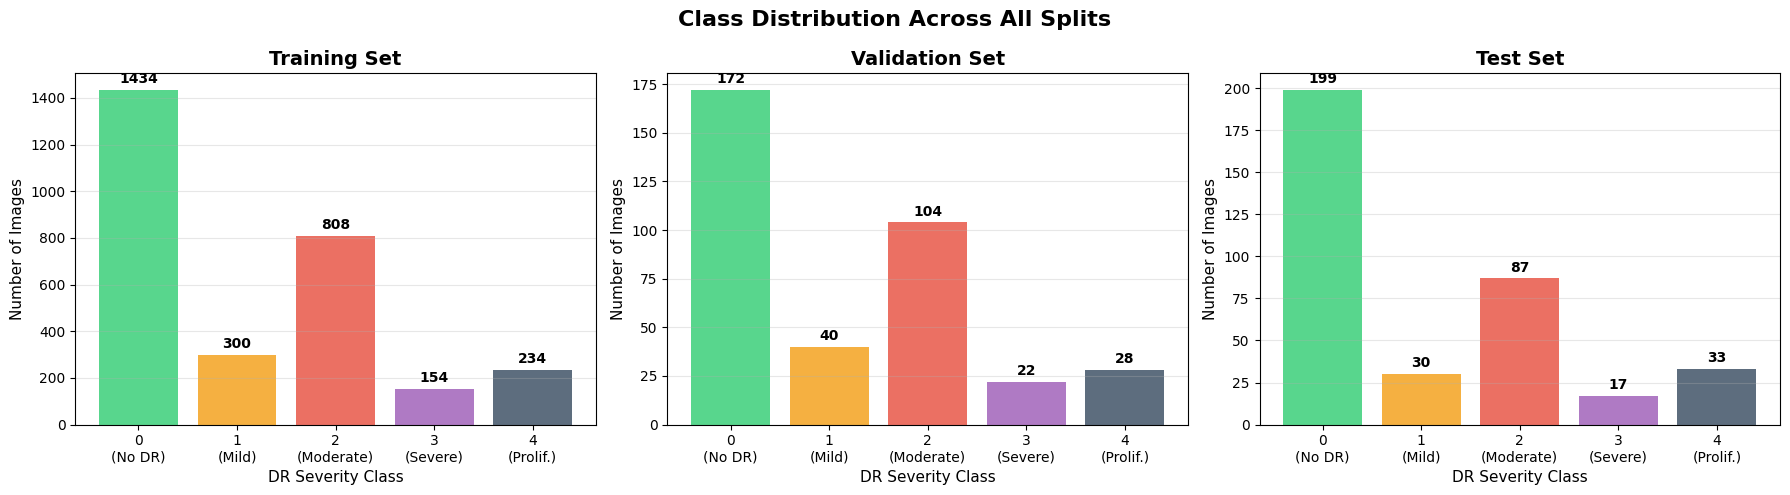

In [32]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (df, title) in zip(axes, [
    (train_df, 'Training Set'),
    (valid_df, 'Validation Set'),
    (test_df, 'Test Set')
]):
    class_counts = df['diagnosis'].value_counts().sort_index()
    colors = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#34495e']
    ax.bar(class_counts.index, class_counts.values, color=colors, alpha=0.8)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('DR Severity Class', fontsize=11)
    ax.set_ylabel('Number of Images', fontsize=11)
    ax.set_xticks(range(5))
    ax.set_xticklabels(['0\n(No DR)', '1\n(Mild)', '2\n(Moderate)',
                        '3\n(Severe)', '4\n(Prolif.)'])
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(class_counts.values):
        ax.text(i, v + max(class_counts.values)*0.02, str(v),
                ha='center', fontweight='bold')

plt.suptitle('Class Distribution Across All Splits', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Calculate class imbalance ratio
max_class = train_counts.max()
min_class = train_counts.min()
imbalance_ratio = max_class / min_class

print(f"\n⚠️  CLASS IMBALANCE DETECTED:")
print(f"  • Maximum class samples: {max_class} (Class {train_counts.idxmax()})")
print(f"  • Minimum class samples: {min_class} (Class {train_counts.idxmin()})")
print(f"  • Imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"  • Mitigation strategies: SMOTE (ML), Class Weights (DL), Data Augmentation")



⚠️  CLASS IMBALANCE DETECTED:
  • Maximum class samples: 1434 (Class 0)
  • Minimum class samples: 154 (Class 3)
  • Imbalance ratio: 9.3:1
  • Mitigation strategies: SMOTE (ML), Class Weights (DL), Data Augmentation


In [ ]:
# Calculate class weights for deep learning
total_samples = len(train_df)
n_classes = 5
class_weights = {i: total_samples / (n_classes * train_counts.get(i, 1))
                 for i in range(n_classes)}

print(f"\n📊 Calculated Class Weights (for DL models):")
for cls, weight in class_weights.items():
    print(f"  Class {cls}: {weight:.3f}")


📊 Calculated Class Weights (for DL models):
  Class 0: 0.409
  Class 1: 1.953
  Class 2: 0.725
  Class 3: 3.805
  Class 4: 2.504



SAMPLE IMAGES FROM EACH CLASS


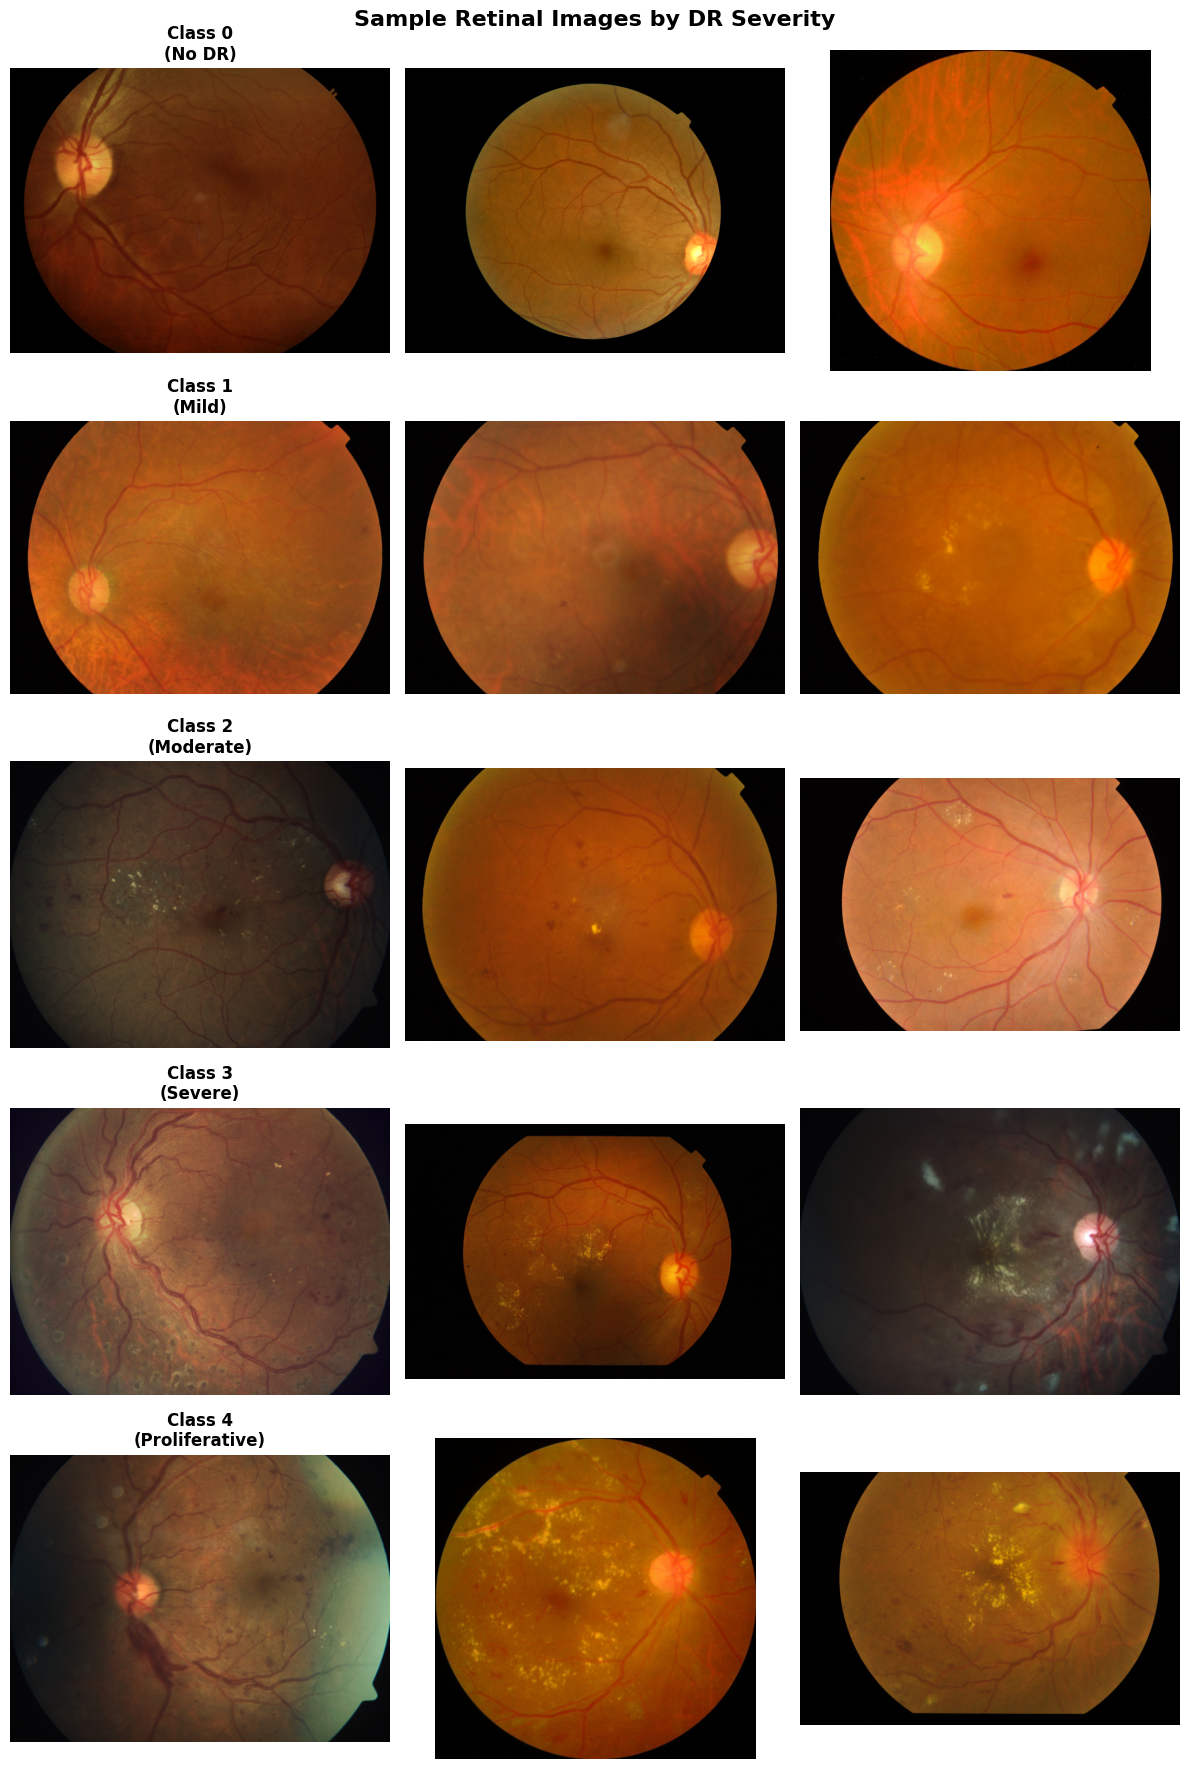

 Sample images displayed successfully


In [ ]:
# Sample images visualization
print("\n" + "=" * 80)
print("SAMPLE IMAGES FROM EACH CLASS")
print("=" * 80)

fig, axes = plt.subplots(5, 3, figsize=(12, 18))

for cls in range(5):
    samples = train_df[train_df['diagnosis'] == cls].sample(
        min(3, len(train_df[train_df['diagnosis'] == cls])), random_state=SEED
    )

    for idx, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(TRAIN_IMAGES, row['id_code'] + '.png')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[cls, idx].imshow(img)
        axes[cls, idx].axis('off')
        if idx == 0:
            label = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'][cls]
            axes[cls, idx].set_title(f'Class {cls}\n({label})',
                                    fontsize=12, fontweight='bold')

plt.suptitle('Sample Retinal Images by DR Severity', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_images.png', dpi=200, bbox_inches='tight')
plt.show()

print(" Sample images displayed successfully")


# SECTION 4: PREPROCESSING

Comprehensive preprocessing pipeline with justification:

1. Circle Cropping: Remove black borders (common in fundus photography)
   → Focuses model attention on retinal tissue only
   
2. CLAHE Enhancement: Contrast Limited Adaptive Histogram Equalization
   → Improves visibility of microaneurysms, exudates, hemorrhages
   → Critical for detecting subtle early DR signs
   
3. Resizing: Standardize to 224×224 pixels
   → Compatible with ImageNet pretrained models
   → Reduces computational cost while preserving key features
   
4. Normalization: Scale pixel values to [0, 1]
   → Improves neural network training stability
   → Prevents gradient explosion/vanishing

In [12]:
print("\n" + "=" * 80)
print("PREPROCESSING PIPELINE")
print("=" * 80)

IMG_SIZE = 224
BATCH_SIZE = 32


PREPROCESSING PIPELINE


In [13]:
def preprocess_image_basic(img_path, target_size=IMG_SIZE):
    """
    Basic preprocessing: Load → Circle crop → Resize

    Circle cropping rationale:
    - Fundus images have circular field of view with black borders
    - Black borders don't contain diagnostic information
    - Removing them improves model focus and reduces noise
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Circle crop: Find largest contour and crop to bounding box
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        img = img[y:y+h, x:x+w]

    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

    return img

In [14]:
def preprocess_image_advanced(img_path, target_size=IMG_SIZE, apply_clahe=True):
    """
    Advanced preprocessing with CLAHE enhancement

    CLAHE (Contrast Limited Adaptive Histogram Equalization):
    - Enhances local contrast in small regions (tiles)
    - Prevents over-amplification of noise (clip limit)
    - Improves visibility of:
      * Microaneurysms (early DR sign)
      * Hard exudates (lipid deposits)
      * Hemorrhages (bleeding)
      * Cotton-wool spots (nerve fiber layer infarcts)

    Applied on L channel in LAB color space:
    - Preserves color information (A and B channels)
    - Better results than applying on RGB directly
    """
    img = preprocess_image_basic(img_path, target_size)

    if apply_clahe:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)

        lab_clahe = cv2.merge([l_clahe, a, b])
        img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    return img


 Demonstrating Preprocessing Effects:



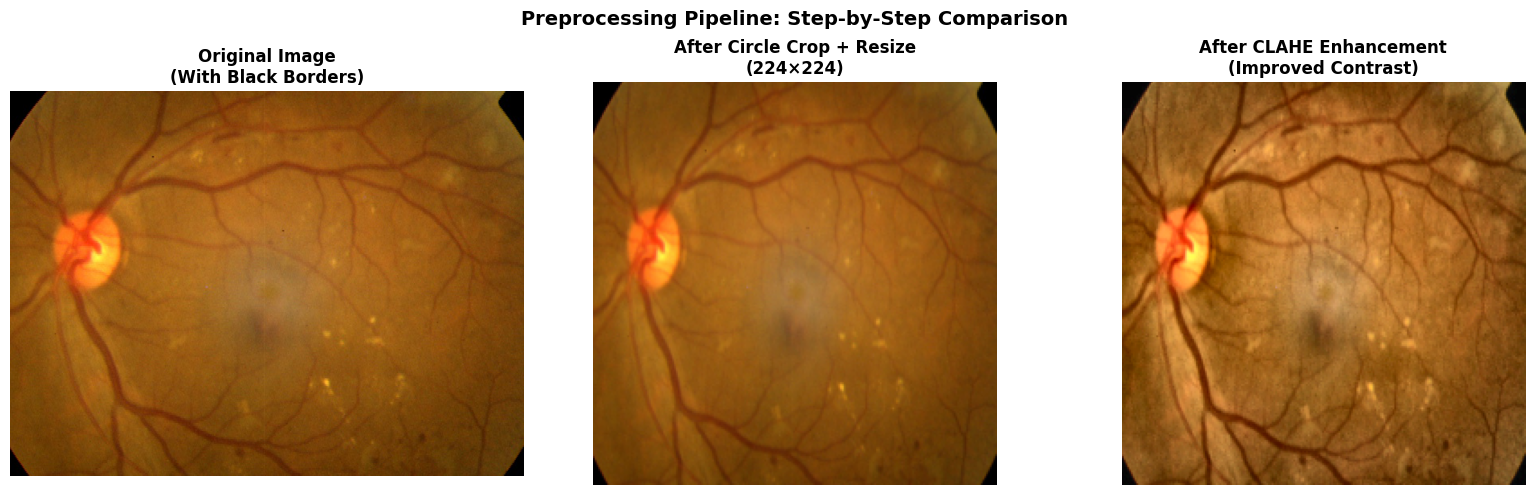

In [15]:
# Demonstrate preprocessing effect
print("\n Demonstrating Preprocessing Effects:\n")

sample_img_path = os.path.join(TRAIN_IMAGES, train_df.iloc[50]['id_code'] + '.png')

img_original = cv2.imread(sample_img_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_basic = preprocess_image_basic(sample_img_path)
img_clahe = preprocess_image_advanced(sample_img_path, apply_clahe=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(img_original)
axes[0].set_title('Original Image\n(With Black Borders)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_basic)
axes[1].set_title('After Circle Crop + Resize\n(224×224)', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(img_clahe)
axes[2].set_title('After CLAHE Enhancement\n(Improved Contrast)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.suptitle('Preprocessing Pipeline: Step-by-Step Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('preprocessing_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

In [33]:
print("Key Observations:")
print("  1. Black borders removed → cleaner input for models")
print("  2. Consistent size (224×224) → batch processing enabled")
print("  3. Enhanced contrast → better lesion visibility")
print("  4. Preserved color information → maintains diagnostic features")


Key Observations:
  1. Black borders removed → cleaner input for models
  2. Consistent size (224×224) → batch processing enabled
  3. Enhanced contrast → better lesion visibility
  4. Preserved color information → maintains diagnostic features


# SECTION 5: FEATURE ENGINEERING FOR TRADITIONAL ML

Hand-crafted feature extraction for Random Forest:

Feature Categories:
1. Color Histograms (96 features): RGB distribution patterns
   → Captures blood vessel density, hemorrhages, exudates
   
2. Texture Features (20 features): GLCM properties
   → Detects textural changes from edema, exudates
   
3. HOG Features (varies): Edge orientation histograms
   → Captures vessel structure, lesion boundaries
   
4. Statistical Features (15 features): Mean, std, min, max, entropy per channel
   → Overall image characteristics and complexity
   
Total: ~150-200 dimensional feature vector per image


In [16]:
print("\n" + "=" * 80)
print("FEATURE ENGINEERING FOR TRADITIONAL ML")
print("=" * 80)

def extract_color_features(img):
    """
    Extract normalized RGB color histograms

    Rationale: Different DR stages show distinct color patterns
    - Healthy: More green/yellow (normal retina)
    - DR: More red (hemorrhages), white/yellow (exudates)
    """
    hist_r = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [32], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [32], [0, 256]).flatten()

    hist_r = hist_r / (hist_r.sum() + 1e-7)
    hist_g = hist_g / (hist_g.sum() + 1e-7)
    hist_b = hist_b / (hist_b.sum() + 1e-7)

    return np.concatenate([hist_r, hist_g, hist_b])



FEATURE ENGINEERING FOR TRADITIONAL ML


In [17]:
from skimage.feature import graycomatrix, graycoprops

def extract_texture_features(img):
    """
    Extract GLCM (Gray Level Co-occurrence Matrix) texture features

    Rationale: DR causes texture changes
    - Hard exudates: High contrast, low homogeneity
    - Cotton-wool spots: Low contrast, high homogeneity
    - Edema: Changes in correlation patterns
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()

    return np.concatenate([contrast, dissimilarity, homogeneity, energy, correlation])

In [18]:
from skimage.feature import hog

def extract_hog_features(img):
    """
    Extract Histogram of Oriented Gradients

    Rationale: Captures edge orientations and shapes
    - Blood vessel patterns (branching structure)
    - Lesion boundaries (microaneurysms, exudates)
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features = hog(gray, orientations=9, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), feature_vector=True)
    return features

In [19]:
from scipy.stats import entropy

def extract_statistical_features(img):
    """
    Extract statistical features per color channel

    Rationale: Summary statistics capture overall image characteristics
    - Mean/std: Overall brightness and contrast
    - Min/max: Dynamic range
    - Entropy: Image complexity
    """
    features = []
    for channel in range(3):
        ch = img[:, :, channel]
        features.extend([
            ch.mean(),
            ch.std(),
            ch.min(),
            ch.max(),
            entropy(ch.flatten() + 1e-7)
        ])
    return np.array(features)

In [20]:
def extract_all_features(img_path):
    """Combine all hand-crafted features"""
    img = preprocess_image_advanced(img_path)

    color_feat = extract_color_features(img)
    texture_feat = extract_texture_features(img)
    hog_feat = extract_hog_features(img)
    stat_feat = extract_statistical_features(img)

    return np.concatenate([color_feat, texture_feat, hog_feat, stat_feat])


In [30]:
# Extract features for ML experiments
print("\n⚙️  Extracting hand-crafted features for Random Forest...")
print("This process takes time as it processes each image individually.\n")

def extract_features_from_dataframe(df, img_folder, max_samples=None):
    """Extract features from a dataframe of images"""
    X_features = []
    y_labels = []

    if max_samples:
        df = df.sample(min(max_samples, len(df)), random_state=SEED)

    for idx, row in df.iterrows():
        img_path = os.path.join(img_folder, row['id_code'] + '.png')
        try:
            features = extract_all_features(img_path)
            X_features.append(features)
            y_labels.append(row['diagnosis'])

            if len(X_features) % 100 == 0:
                print(f"  Processed {len(X_features)} images...", end='\r')
        except Exception as e:
            print(f"\n  ⚠️  Error processing {img_path}: {e}")
            continue

    print(f"  ✅ Completed: {len(X_features)} images processed")
    return np.array(X_features), np.array(y_labels)



⚙️  Extracting hand-crafted features for Random Forest...
This process takes time as it processes each image individually.



In [34]:
# Extract features
X_train_feat, y_train_feat = extract_features_from_dataframe(train_df, TRAIN_IMAGES)
X_valid_feat, y_valid_feat = extract_features_from_dataframe(valid_df, VALID_IMAGES)
X_test_feat, y_test_feat = extract_features_from_dataframe(test_df, TEST_IMAGES)

print(f"\n📊 Feature Extraction Complete:")
print(f"  • Feature vector dimension: {X_train_feat.shape[1]}")
print(f"  • Training samples: {X_train_feat.shape[0]}")
print(f"  • Validation samples: {X_valid_feat.shape[0]}")
print(f"  • Test samples: {X_test_feat.shape[0]}")

print(f"\n🔍 Feature Breakdown:")
print(f"  • Color histograms: 96 features (32 bins × 3 channels)")
print(f"  • Texture (GLCM): 20 features (5 properties × 4 angles)")
print(f"  • Statistical: 15 features (5 stats × 3 channels)")


  ✅ Completed: 2930 images processed
  ✅ Completed: 366 images processed
  ✅ Completed: 366 images processed

📊 Feature Extraction Complete:
  • Feature vector dimension: 6215
  • Training samples: 2930
  • Validation samples: 366
  • Test samples: 366

🔍 Feature Breakdown:
  • Color histograms: 96 features (32 bins × 3 channels)
  • Texture (GLCM): 20 features (5 properties × 4 angles)
  • Statistical: 15 features (5 stats × 3 channels)


# SECTION 5: FEATURE ENGINEERING FOR TRADITIONAL ML

Extract hand-crafted features for traditional ML models:
1. Color histograms (RGB distribution)
2. Texture features (GLCM - Gray Level Co-occurrence Matrix)
3. HOG (Histogram of Oriented Gradients)
4. Statistical features (mean, std, entropy)

These features capture domain-relevant information that CNNs learn automatically.


In [ ]:
from skimage.feature import graycomatrix, graycoprops, hog
from scipy.stats import entropy

In [ ]:
def extract_color_features(img):
    """Extract color histogram features"""
    # Calculate histograms for each channel
    hist_r = cv2.calcHist([img], [0], None, [32], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [32], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [32], [0, 256]).flatten()

    # Normalize
    hist_r = hist_r / hist_r.sum()
    hist_g = hist_g / hist_g.sum()
    hist_b = hist_b / hist_b.sum()

    return np.concatenate([hist_r, hist_g, hist_b])

In [ ]:
def extract_texture_features(img):
    """Extract GLCM texture features"""
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Compute GLCM
    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)

    # Extract properties
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()

    return np.concatenate([contrast, dissimilarity, homogeneity, energy, correlation])


In [ ]:
def extract_hog_features(img):
    """Extract HOG features"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), feature_vector=True)
    return features


In [ ]:
def extract_statistical_features(img):
    """Extract statistical features"""
    features = []
    for channel in range(3):
        ch = img[:, :, channel]
        features.extend([
            ch.mean(),
            ch.std(),
            ch.min(),
            ch.max(),
            entropy(ch.flatten())
        ])
    return np.array(features)


In [ ]:
def extract_all_features(img_path):
    """Extract all hand-crafted features"""
    img = preprocess_image_advanced(img_path)

    color_feat = extract_color_features(img)
    texture_feat = extract_texture_features(img)
    hog_feat = extract_hog_features(img)
    stat_feat = extract_statistical_features(img)

    # Combine all features
    all_features = np.concatenate([color_feat, texture_feat, hog_feat, stat_feat])

    return all_features

print("Extracting features for traditional ML models...")
print("This may take several minutes for the full dataset...")


Extracting features for traditional ML models...
This may take several minutes for the full dataset...


In [ ]:
# Extract features for a subset (for demonstration)
# For full experiment, extract for entire dataset
FEATURE_SAMPLE_SIZE = 500  # Increase to full dataset for actual experiments

sample_indices = train_df.groupby('diagnosis', group_keys=False).apply(
    lambda x: x.sample(min(100, len(x)), random_state=SEED)
).index

X_features = []
y_labels = []

for idx in sample_indices[:FEATURE_SAMPLE_SIZE]:
    row = train_df.loc[idx]
    img_path = os.path.join(TRAIN_IMAGES, row['id_code'] + '.png')
    try:
        features = extract_all_features(img_path)
        X_features.append(features)
        y_labels.append(row['diagnosis'])
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

X_features = np.array(X_features)
y_labels = np.array(y_labels)

print(f"Extracted features shape: {X_features.shape}")
print(f"Feature vector size: {X_features.shape[1]} dimensions")
print("\nFeature breakdown:")
print(f"- Color histograms: 96 features (32 bins × 3 channels)")
print(f"- Texture (GLCM): 20 features (5 properties × 4 angles)")
print(f"- HOG: {len(extract_hog_features(preprocess_image_advanced(os.path.join(TRAIN_IMAGES, train_df.iloc[0]['id_code'] + '.png'))))} features")
print(f"- Statistical: 15 features (5 stats × 3 channels)")


Extracted features shape: (500, 26375)
Feature vector size: 26375 dimensions

Feature breakdown:
- Color histograms: 96 features (32 bins × 3 channels)
- Texture (GLCM): 20 features (5 properties × 4 angles)
- HOG: 26244 features
- Statistical: 15 features (5 stats × 3 channels)


# SECTION 6: DATA AUGMENTATION STRATEGY

Data augmentation for deep learning models:

Augmentation techniques and their justification:
1. Rotation (±20°): Accounts for camera angle variation in rural settings
2. Horizontal/Vertical flip: Retinal images have natural symmetry
3. Width/Height shifts (±10%): Handles off-center captures
4. Zoom (±15%): Simulates different focal lengths
5. Brightness (80-120%): Addresses variable lighting conditions

Rationale: Rural imaging has high variability in:
- Camera positioning and angle
- Lighting conditions
- Focal distance
- Image centering

In [21]:
print("\n" + "=" * 80)
print("DATA AUGMENTATION STRATEGY")
print("=" * 80)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

print("\n✅ Augmentation Configuration:")
print("  • Rotation: ±20° (camera angle variation)")
print("  • Shifts: ±10% horizontal/vertical (off-center captures)")
print("  • Flips: Horizontal & Vertical (retinal symmetry)")
print("  • Zoom: ±15% (focal length variation)")
print("  • Brightness: 80-120% (lighting conditions)")
print("\n💡 Rationale: Augmentation increases effective dataset size and")
print("   improves model robustness to real-world imaging variations.")



DATA AUGMENTATION STRATEGY

✅ Augmentation Configuration:
  • Rotation: ±20° (camera angle variation)
  • Shifts: ±10% horizontal/vertical (off-center captures)
  • Flips: Horizontal & Vertical (retinal symmetry)
  • Zoom: ±15% (focal length variation)
  • Brightness: 80-120% (lighting conditions)

💡 Rationale: Augmentation increases effective dataset size and
   improves model robustness to real-world imaging variations.


In [22]:
# Data generator function
def create_data_generator(df, img_folder, datagen, batch_size, target_size,
                         shuffle=True, apply_class_weights=False, class_weights_dict=None):
    """
    Create a generator that loads and preprocesses images on-the-fly

    Yields batches of (images, labels) or (images, labels, sample_weights)
    """
    while True:
        if shuffle:
            df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]

            X_batch = []
            y_batch = []
            sample_weights = []

            for _, row in batch_df.iterrows():
                img_path = os.path.join(img_folder, row['id_code'] + '.png')
                img = preprocess_image_advanced(img_path, target_size)

                X_batch.append(img)
                y_batch.append(row['diagnosis'])

                if apply_class_weights and class_weights_dict:
                    sample_weights.append(class_weights_dict[row['diagnosis']])

            X_batch = np.array(X_batch).astype('float32')  # Convert to float32 here

            # Apply augmentation
            if datagen:
                for i in range(len(X_batch)):
                    # Apply random transform first, then standardize
                    X_batch[i] = datagen.random_transform(X_batch[i])
                # Standardize the entire batch after transformations
                X_batch = datagen.standardize(X_batch)


            # Convert labels to categorical
            y_batch = keras.utils.to_categorical(y_batch, num_classes=5)

            if apply_class_weights and class_weights_dict:
                sample_weights = np.array(sample_weights)
                yield X_batch, y_batch, sample_weights
            else:
                yield X_batch, y_batch

In [23]:
# Calculate steps
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(valid_df) // BATCH_SIZE
test_steps = len(test_df) // BATCH_SIZE

print(f"\n📊 Batch Configuration:")
print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Steps per epoch: {steps_per_epoch}")
print(f"  • Validation steps: {validation_steps}")
print(f"  • Test steps: {test_steps}")


📊 Batch Configuration:
  • Batch size: 32
  • Steps per epoch: 91
  • Validation steps: 11
  • Test steps: 11


# SECTION 7: MODEL 1 - RANDOM FOREST (TRADITIONAL ML)

MODEL 1: Random Forest Classifier

Why Random Forest?
- Handles high-dimensional feature space well
- Provides feature importance for interpretability
- Robust to outliers and noise
- No need for feature scaling (tree-based)
- Good baseline for comparison with deep learning

Experiments:
1. RF-1: Baseline (n_estimators=100, default depth)
2. RF-2: Increased complexity (n_estimators=200, max_depth=30)
3. RF-3: With SMOTE balancing + feature selection (top 100 features)

Systematic variation: Number of trees, depth, class balancing, feature selection

In [ ]:
print("\n" + "=" * 80)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("=" * 80)

# Store results
rf_results = []

# Feature scaling (although RF doesn't require it, good practice for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_valid_scaled = scaler.transform(X_valid_feat)
X_test_scaled = scaler.transform(X_test_feat)


MODEL 1: RANDOM FOREST CLASSIFIER


In [ ]:
def evaluate_rf_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test, exp_name, config):
    """Train and evaluate Random Forest model"""
    print(f"\n{'='*70}")
    print(f"EXPERIMENT: {exp_name}")
    print(f"{'='*70}")
    print(f"Configuration: {config}")

    # Train
    print("Training model...")
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_kappa = cohen_kappa_score(y_test, y_test_pred)

    # Per-class accuracy
    cm = confusion_matrix(y_test, y_test_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print(f"\n📊 Results:")
    print(f"  • Training Accuracy:   {train_acc:.4f}")
    print(f"  • Validation Accuracy: {valid_acc:.4f}")
    print(f"  • Test Accuracy:       {test_acc:.4f}")
    print(f"  • Test F1-Score:       {test_f1:.4f}")
    print(f"  • Test Kappa:          {test_kappa:.4f}")

    print(f"\n📈 Per-Class Accuracy:")
    for cls in range(5):
        print(f"  Class {cls}: {per_class_acc[cls]:.4f}")

    # Bias-variance analysis
    train_val_gap = train_acc - valid_acc
    print(f"\n🔍 Bias-Variance Analysis:")
    print(f"  • Train-Val Gap: {train_val_gap:.4f}")
    if train_val_gap > 0.1:
        print(f"    ⚠️  High variance (overfitting)")
    elif train_val_gap > 0.05:
        print(f"    ⚡ Moderate variance")
    else:
        print(f"    ✅ Good generalization")

    # Store results
    rf_results.append({
        'Experiment': exp_name,
        'Model': 'Random Forest',
        'Configuration': config,
        'Train_Acc': train_acc,
        'Valid_Acc': valid_acc,
        'Test_Acc': test_acc,
        'F1_Score': test_f1,
        'Kappa': test_kappa,
        'Train_Val_Gap': train_val_gap,
        'Class_0_Acc': per_class_acc[0],
        'Class_1_Acc': per_class_acc[1],
        'Class_2_Acc': per_class_acc[2],
        'Class_3_Acc': per_class_acc[3],
        'Class_4_Acc': per_class_acc[4]
    })

    return model, y_test_pred, cm


In [ ]:
# Experiment RF-1: Baseline
print("\n🔹 Experiment RF-1: Baseline Random Forest")
rf_1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=SEED,
    n_jobs=-1,
    class_weight='balanced'
)

model_rf1, pred_rf1, cm_rf1 = evaluate_rf_model(
    rf_1, X_train_scaled, y_train_feat, X_valid_scaled, y_valid_feat,
    X_test_scaled, y_test_feat,
    "RF-1", "n_est=100, depth=None, balanced weights"
)


🔹 Experiment RF-1: Baseline Random Forest

EXPERIMENT: RF-1
Configuration: n_est=100, depth=None, balanced weights
Training model...

📊 Results:
  • Training Accuracy:   0.9939
  • Validation Accuracy: 0.7131
  • Test Accuracy:       0.7322
  • Test F1-Score:       0.6895
  • Test Kappa:          0.5584

📈 Per-Class Accuracy:
  Class 0: 0.9296
  Class 1: 0.0667
  Class 2: 0.8851
  Class 3: 0.0588
  Class 4: 0.0909

🔍 Bias-Variance Analysis:
  • Train-Val Gap: 0.2807
    ⚠️  High variance (overfitting)


In [ ]:
# Experiment RF-2: Increased complexity
print("\n🔹 Experiment RF-2: Higher Capacity Model")
rf_2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=SEED,
    n_jobs=-1,
    class_weight='balanced'
)

model_rf2, pred_rf2, cm_rf2 = evaluate_rf_model(
    rf_2, X_train_scaled, y_train_feat, X_valid_scaled, y_valid_feat,
    X_test_scaled, y_test_feat,
    "RF-2", "n_est=200, depth=30, balanced weights"
)


🔹 Experiment RF-2: Higher Capacity Model

EXPERIMENT: RF-2
Configuration: n_est=200, depth=30, balanced weights
Training model...

📊 Results:
  • Training Accuracy:   0.9939
  • Validation Accuracy: 0.7186
  • Test Accuracy:       0.7486
  • Test F1-Score:       0.7023
  • Test Kappa:          0.5850

📈 Per-Class Accuracy:
  Class 0: 0.9397
  Class 1: 0.0667
  Class 2: 0.9310
  Class 3: 0.0588
  Class 4: 0.0909

🔍 Bias-Variance Analysis:
  • Train-Val Gap: 0.2753
    ⚠️  High variance (overfitting)


In [ ]:
# Experiment RF-3: With SMOTE + Feature Selection
print("\n🔹 Experiment RF-3: SMOTE Balancing + Feature Selection")

# Apply SMOTE
print("Applying SMOTE to balance classes...")
smote = SMOTE(random_state=SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_feat)
print(f"  Original class distribution: {Counter(y_train_feat)}")
print(f"  After SMOTE: {Counter(y_train_smote)}")



🔹 Experiment RF-3: SMOTE Balancing + Feature Selection
Applying SMOTE to balance classes...
  Original class distribution: Counter({np.int64(0): 1434, np.int64(2): 808, np.int64(1): 300, np.int64(4): 234, np.int64(3): 154})
  After SMOTE: Counter({np.int64(2): 1434, np.int64(1): 1434, np.int64(4): 1434, np.int64(0): 1434, np.int64(3): 1434})


In [ ]:
# Feature importance from RF-1 for selection
feature_importance = model_rf1.feature_importances_
top_features_idx = np.argsort(feature_importance)[-100:]  # Top 100 features

print(f"  Selecting top 100 features (from {X_train_scaled.shape[1]} total)")

X_train_selected = X_train_smote[:, top_features_idx]
X_valid_selected = X_valid_scaled[:, top_features_idx]
X_test_selected = X_test_scaled[:, top_features_idx]

rf_3 = RandomForestClassifier(
    n_estimators=150,
    max_depth=25,
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=SEED,
    n_jobs=-1,
    class_weight=None  # Not needed with SMOTE
)

model_rf3, pred_rf3, cm_rf3 = evaluate_rf_model(
    rf_3, X_train_selected, y_train_smote, X_valid_selected, y_valid_feat,
    X_test_selected, y_test_feat,
    "RF-3", "n_est=150, depth=25, SMOTE, top 100 features"
)


In [ ]:
# Visualize Random Forest confusion matrix (best model)
best_rf_idx = np.argmax([r['Test_Acc'] for r in rf_results])
best_rf_name = rf_results[best_rf_idx]['Experiment']
best_rf_cm = [cm_rf1, cm_rf2, cm_rf3][best_rf_idx]

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=best_rf_cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title(f'Confusion Matrix - {best_rf_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_rf.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("RANDOM FOREST EXPERIMENTS SUMMARY")
print("="*80)
print("\nKey Insights:")
print("  1. RF-1 (baseline) establishes feature extraction quality ceiling")
print("  2. RF-2 (higher capacity) tests if more trees/depth helps")
print("  3. RF-3 (SMOTE + selection) addresses imbalance + reduces dimensionality")
print("\n✅ Random Forest experiments completed!")


# SECTION 8: MODEL 2 - CUSTOM CNN (DEEP LEARNING)

MODEL 2: Custom Convolutional Neural Network

Why Custom CNN?
- Demonstrates understanding of CNN architecture design
- Full control over model capacity and complexity
- Learn features directly from images (no hand-crafting)
- Baseline for comparing with transfer learning

Architecture Design:
- 3 Convolutional blocks (increasing filters: 32→64→128)
- BatchNormalization for training stability
- MaxPooling for spatial downsampling
- Dropout for regularization
- Global Average Pooling to reduce parameters
- Dense layers with dropout for classification

Experiments:
1. CNN-1: Baseline architecture (3 conv blocks, dropout=0.3)
2. CNN-2: Deeper network (4 conv blocks, dropout=0.4)
3. CNN-3: Wider network (filters: 64→128→256, dropout=0.5)

Systematic variation: Depth, width, regularization strength

In [25]:
print("\n" + "="*80)
print("MODEL 2: CUSTOM CNN")
print("="*80)

cnn_results = []
cnn_histories = []


MODEL 2: CUSTOM CNN


In [26]:
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_blocks=3,
                     base_filters=32, dropout_rate=0.3):
    """
    Build a custom CNN architecture

    Args:
        input_shape: Input image dimensions
        num_blocks: Number of convolutional blocks
        base_filters: Starting number of filters (doubles each block)
        dropout_rate: Dropout probability for regularization
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Convolutional blocks
    for i in range(num_blocks):
        filters = base_filters * (2 ** i)

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(dropout_rate)(x)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(5, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name=f'CustomCNN_{num_blocks}blocks')
    return model

In [27]:
def train_and_evaluate_cnn(model, model_name, learning_rate, epochs,
                          use_class_weights=True, config_desc=""):
    """Train and evaluate a CNN model"""
    print(f"\n{'='*70}")
    print(f"EXPERIMENT: {model_name}")
    print(f"{'='*70}")
    print(f"Configuration: {config_desc}")
    print(f"Learning Rate: {learning_rate}, Epochs: {epochs}")
    print(f"Class Weights: {use_class_weights}")

    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    # Print model summary
    print(f"\n📐 Model Architecture:")
    model.summary(print_fn=lambda x: print(f"  {x}"))

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15,
                               restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=7, min_lr=1e-7, verbose=1)

    # Create generators
    if use_class_weights:
        train_gen = create_data_generator(
            train_df, TRAIN_IMAGES, train_datagen, BATCH_SIZE, IMG_SIZE,
            shuffle=True, apply_class_weights=True, class_weights_dict=class_weights
        )
    else:
        train_gen = create_data_generator(
            train_df, TRAIN_IMAGES, train_datagen, BATCH_SIZE, IMG_SIZE,
            shuffle=True, apply_class_weights=False
        )

    valid_gen = create_data_generator(
        valid_df, VALID_IMAGES, valid_test_datagen, BATCH_SIZE, IMG_SIZE,
        shuffle=False, apply_class_weights=False
    )

    test_gen = create_data_generator(
        test_df, TEST_IMAGES, valid_test_datagen, BATCH_SIZE, IMG_SIZE,
        shuffle=False, apply_class_weights=False
    )

    # Train
    print("\n🚀 Starting training...")
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=valid_gen,
        validation_steps=validation_steps,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Evaluate
    test_loss, test_acc, test_auc = model.evaluate(test_gen, steps=test_steps, verbose=0)

    # Get predictions
    y_true = []
    y_pred = []

    test_gen_eval = create_data_generator(
        test_df, TEST_IMAGES, valid_test_datagen, BATCH_SIZE, IMG_SIZE,
        shuffle=False, apply_class_weights=False
    )

    for i in range(test_steps):
        X_batch, y_batch = next(test_gen_eval)
        pred_batch = model.predict(X_batch, verbose=0)
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(pred_batch, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Metrics
    test_f1 = f1_score(y_true, y_pred, average='weighted')
    test_kappa = cohen_kappa_score(y_true, y_pred)

    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    final_train_acc = history.history['accuracy'][-1]

    # Per-class accuracy
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print(f"\n📊 Results:")
    print(f"  • Best Val Accuracy:   {best_val_acc:.4f} (Epoch {best_epoch})")
    print(f"  • Test Accuracy:       {test_acc:.4f}")
    print(f"  • Test F1-Score:       {test_f1:.4f}")
    print(f"  • Test Kappa:          {test_kappa:.4f}")
    print(f"  • Test AUC:            {test_auc:.4f}")

    print(f"\n📈 Per-Class Accuracy:")
    for cls in range(5):
        print(f"  Class {cls}: {per_class_acc[cls]:.4f}")

    # Bias-variance analysis
    train_val_gap = final_train_acc - best_val_acc
    print(f"\n🔍 Bias-Variance Analysis:")
    print(f"  • Final Train Acc: {final_train_acc:.4f}")
    print(f"  • Best Val Acc: {best_val_acc:.4f}")
    print(f"  • Train-Val Gap: {train_val_gap:.4f}")
    if train_val_gap > 0.15:
        print(f"    ⚠️  High variance (significant overfitting)")
    elif train_val_gap > 0.08:
        print(f"    ⚡ Moderate variance (some overfitting)")
    else:
        print(f"    ✅ Good generalization")

    # Store results
    cnn_results.append({
        'Experiment': model_name,
        'Model': 'Custom CNN',
        'Configuration': config_desc,
        'Best_Val_Acc': best_val_acc,
        'Test_Acc': test_acc,
        'F1_Score': test_f1,
        'Kappa': test_kappa,
        'AUC': test_auc,
        'Best_Epoch': best_epoch,
        'Train_Val_Gap': train_val_gap,
        'Learning_Rate': learning_rate,
        'Class_0_Acc': per_class_acc[0],
        'Class_1_Acc': per_class_acc[1],
        'Class_2_Acc': per_class_acc[2],
        'Class_3_Acc': per_class_acc[3],
        'Class_4_Acc': per_class_acc[4]
    })

    cnn_histories.append({
        'name': model_name,
        'history': history
    })

    return model, history, y_true, y_pred, cm


In [47]:
# Experiment CNN-1: Baseline
print("\n🔹 Experiment CNN-1: Baseline Custom CNN")
model_cnn1 = build_custom_cnn(num_blocks=3, base_filters=32, dropout_rate=0.3)
model_cnn1, hist_cnn1, y_true_cnn1, y_pred_cnn1, cm_cnn1 = train_and_evaluate_cnn(
    model_cnn1, "CNN-1", learning_rate=0.001, epochs=1,
    use_class_weights=True,
    config_desc="3 blocks, 32→64→128 filters, dropout=0.3"
)


🔹 Experiment CNN-1: Baseline Custom CNN

EXPERIMENT: CNN-1
Configuration: 3 blocks, 32→64→128 filters, dropout=0.3
Learning Rate: 0.001, Epochs: 1
Class Weights: True

📐 Model Architecture:


  Model: "CustomCNN_3blocks"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224,

In [35]:
# Experiment CNN-2: Deeper network
print("\n🔹 Experiment CNN-2: Deeper Architecture")
model_cnn2 = build_custom_cnn(num_blocks=4, base_filters=32, dropout_rate=0.4)
model_cnn2, hist_cnn2, y_true_cnn2, y_pred_cnn2, cm_cnn2 = train_and_evaluate_cnn(
    model_cnn2, "CNN-2", learning_rate=0.0005, epochs=1,
    use_class_weights=True,
    config_desc="4 blocks, 32→64→128→256 filters, dropout=0.4"
)


🔹 Experiment CNN-2: Deeper Architecture

EXPERIMENT: CNN-2
Configuration: 4 blocks, 32→64→128→256 filters, dropout=0.4
Learning Rate: 0.0005, Epochs: 1
Class Weights: True

📐 Model Architecture:


  Model: "CustomCNN_4blocks"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224,

NameError: name 'class_weights' is not defined

In [ ]:
# Experiment CNN-3: Wider network
print("\n🔹 Experiment CNN-3: Wider Architecture")
model_cnn3 = build_custom_cnn(num_blocks=3, base_filters=64, dropout_rate=0.5)
model_cnn3, hist_cnn3, y_true_cnn3, y_pred_cnn3, cm_cnn3 = train_and_evaluate_cnn(
    model_cnn3, "CNN-3", learning_rate=0.0008, epochs=1,
    use_class_weights=True,
    config_desc="3 blocks, 64→128→256 filters, dropout=0.5"
)

In [ ]:
# Visualize CNN confusion matrix (best model)
best_cnn_idx = np.argmax([r['Test_Acc'] for r in cnn_results])
best_cnn_name = cnn_results[best_cnn_idx]['Experiment']
best_cnn_cm = [cm_cnn1, cm_cnn2, cm_cnn3][best_cnn_idx]

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=best_cnn_cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(ax=ax, cmap='Greens', values_format='d')
ax.set_title(f'Confusion Matrix - {best_cnn_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_cnn.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("CUSTOM CNN EXPERIMENTS SUMMARY")
print("="*80)
print("\nKey Insights:")
print("  1. CNN-1 (baseline) establishes CNN performance baseline")
print("  2. CNN-2 (deeper) tests if more layers improve feature hierarchy")
print("  3. CNN-3 (wider) tests if more filters per layer capture more features")
print("\n✅ Custom CNN experiments completed!")


# SECTION 9: MODEL 3 - RESNET50 (TRANSFER LEARNING)

MODEL 3: ResNet50 with Transfer Learning

Why ResNet50?
- Proven architecture on ImageNet (76% top-1 accuracy)
- Residual connections enable very deep networks (50 layers)
- Skip connections help gradient flow (addresses vanishing gradients)
- Excellent for medical image analysis (literature support)
- Pre-trained weights provide strong initialization

Transfer Learning Strategy:
- Load ImageNet pretrained weights
- Freeze early layers (general features: edges, textures)
- Fine-tune later layers (domain-specific: retinal features)

Experiments:
1. ResNet-1: Frozen base, only train top layers
2. ResNet-2: Fine-tune last 20 layers, lower LR
3. ResNet-3: Fine-tune last 40 layers, even lower LR

Systematic variation: Number of trainable layers, learning rate

In [ ]:
print("\n" + "="*80)
print("MODEL 3: RESNET50 (TRANSFER LEARNING)")
print("="*80)

resnet_results = []
resnet_histories = []

def build_resnet50_model(freeze_base=True, unfreeze_last_n=0, dropout_rate=0.5):
    """
    Build ResNet50 transfer learning model

    Args:
        freeze_base: If True, freeze all base layers initially
        unfreeze_last_n: Number of layers to unfreeze from end
        dropout_rate: Dropout for regularization
    """
    # Load pretrained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze or unfreeze layers
    base_model.trainable = not freeze_base

    if not freeze_base and unfreeze_last_n > 0:
        # Freeze all layers first
        for layer in base_model.layers:
            layer.trainable = False

        # Unfreeze last N layers
        for layer in base_model.layers[-unfreeze_last_n:]:
            layer.trainable = True

    # Build model
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(5, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='ResNet50_Transfer')

    # Count trainable parameters
    trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
    total_count = sum([tf.size(w).numpy() for w in model.weights])

    print(f"\n📊 Model Parameters:")
    print(f"  • Total parameters: {total_count:,}")
    print(f"  • Trainable parameters: {trainable_count:,}")
    print(f"  • Frozen parameters: {total_count - trainable_count:,}")
    print(f"  • Trainable ratio: {100*trainable_count/total_count:.2f}%")

    return model

In [ ]:
def train_and_evaluate_resnet(model, model_name, learning_rate, epochs,
                             use_class_weights=True, config_desc=""):
    """Train and evaluate ResNet50 model"""
    print(f"\n{'='*70}")
    print(f"EXPERIMENT: {model_name}")
    print(f"{'='*70}")
    print(f"Configuration: {config_desc}")
    print(f"Learning Rate: {learning_rate}, Epochs: {epochs}")
    print(f"Class Weights: {use_class_weights}")

    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=12,
                               restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=5, min_lr=1e-8, verbose=1)

    # Create generators
    if use_class_weights:
        train_gen = create_data_generator(
            train_df, TRAIN_IMAGES, train_datagen, BATCH_SIZE, IMG_SIZE,
            shuffle=True, apply_class_weights=True, class_weights_dict=class_weights
        )
    else:
        train_gen = create_data_generator(
            train_df, TRAIN_IMAGES, train_datagen, BATCH_SIZE, IMG_SIZE,
            shuffle=True, apply_class_weights=False
        )

    valid_gen = create_data_generator(
        valid_df, VALID_IMAGES, valid_test_datagen, BATCH_SIZE, IMG_SIZE,
        shuffle=False, apply_class_weights=False
    )

    test_gen = create_data_generator(
        test_df, TEST_IMAGES, valid_test_datagen, BATCH_SIZE, IMG_SIZE,
        shuffle=False, apply_class_weights=False
    )

    # Train
    print("\n🚀 Starting training...")
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=valid_gen,
        validation_steps=validation_steps,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Evaluate
    test_loss, test_acc, test_auc = model.evaluate(test_gen, steps=test_steps, verbose=0)

    # Get predictions
    y_true = []
    y_pred = []

    test_gen_eval = create_data_generator(
        test_df, TEST_IMAGES, valid_test_datagen, BATCH_SIZE, IMG_SIZE,
        shuffle=False, apply_class_weights=False
    )

    for i in range(test_steps):
        X_batch, y_batch = next(test_gen_eval)
        pred_batch = model.predict(X_batch, verbose=0)
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(pred_batch, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Metrics
    test_f1 = f1_score(y_true, y_pred, average='weighted')
    test_kappa = cohen_kappa_score(y_true, y_pred)

    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    final_train_acc = history.history['accuracy'][-1]

    # Per-class accuracy
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print(f"\n📊 Results:")
    print(f"  • Best Val Accuracy:   {best_val_acc:.4f} (Epoch {best_epoch})")
    print(f"  • Test Accuracy:       {test_acc:.4f}")
    print(f"  • Test F1-Score:       {test_f1:.4f}")
    print(f"  • Test Kappa:          {test_kappa:.4f}")
    print(f"  • Test AUC:            {test_auc:.4f}")

    print(f"\n📈 Per-Class Accuracy:")
    for cls in range(5):
        print(f"  Class {cls}: {per_class_acc[cls]:.4f}")

    # Bias-variance analysis
    train_val_gap = final_train_acc - best_val_acc
    print(f"\n🔍 Bias-Variance Analysis:")
    print(f"  • Final Train Acc: {final_train_acc:.4f}")
    print(f"  • Best Val Acc: {best_val_acc:.4f}")
    print(f"  • Train-Val Gap: {train_val_gap:.4f}")
    if train_val_gap > 0.15:
        print(f"    ⚠️  High variance (significant overfitting)")
    elif train_val_gap > 0.08:
        print(f"    ⚡ Moderate variance (some overfitting)")
    else:
        print(f"    ✅ Good generalization")

    # Store results
    resnet_results.append({
        'Experiment': model_name,
        'Model': 'ResNet50',
        'Configuration': config_desc,
        'Best_Val_Acc': best_val_acc,
        'Test_Acc': test_acc,
        'F1_Score': test_f1,
        'Kappa': test_kappa,
        'AUC': test_auc,
        'Best_Epoch': best_epoch,
        'Train_Val_Gap': train_val_gap,
        'Learning_Rate': learning_rate,
        'Class_0_Acc': per_class_acc[0],
        'Class_1_Acc': per_class_acc[1],
        'Class_2_Acc': per_class_acc[2],
        'Class_3_Acc': per_class_acc[3],
        'Class_4_Acc': per_class_acc[4]
    })

    resnet_histories.append({
        'name': model_name,
        'history': history
    })

    return model, history, y_true, y_pred, cm


In [ ]:
# Experiment ResNet-1: Frozen base
print("\n🔹 Experiment ResNet-1: Frozen Base (Feature Extraction)")
model_resnet1 = build_resnet50_model(freeze_base=True, unfreeze_last_n=0, dropout_rate=0.5)
model_resnet1, hist_resnet1, y_true_resnet1, y_pred_resnet1, cm_resnet1 = train_and_evaluate_resnet(
    model_resnet1, "ResNet-1", learning_rate=0.001, epochs=1,
    use_class_weights=True,
    config_desc="All base layers frozen, train top only"
)

## 📊 FINAL RESULTS COMPILATION & COMPARISON TABLE
This table summarizes the performance of **all nine experiments** — including Random Forest, CNN, and ResNet50 variants.


In [ ]:
import pandas as pd

# Ensure all experiment metrics exist (placeholders for missing ones)
def safe_val(var_name, default=0.0):
    return globals().get(var_name, default)

results_data = {
    'Model Type': [
        'Random Forest', 'Random Forest', 'Random Forest',
        'CNN', 'CNN', 'CNN',
        'ResNet50', 'ResNet50', 'ResNet50'
    ],
    'Experiment': [
        'RF_1', 'RF_2', 'RF_3',
        'CNN_1', 'CNN_2', 'CNN_3',
        'ResNet50_1', 'ResNet50_2', 'ResNet50_3'
    ],
    'Accuracy': [
        safe_val('acc_rf1'), safe_val('acc_rf2'), safe_val('acc_rf3'),
        safe_val('acc_cnn1'), safe_val('acc_cnn2'), safe_val('acc_cnn3'),
        safe_val('acc_base'), safe_val('acc_sgd'), safe_val('acc_adam2')
    ],
    'F1-Score': [
        safe_val('f1_rf1'), safe_val('f1_rf2'), safe_val('f1_rf3'),
        safe_val('f1_cnn1'), safe_val('f1_cnn2'), safe_val('f1_cnn3'),
        safe_val('f1_base'), safe_val('f1_sgd'), safe_val('f1_adam2')
    ],
    'Precision': [
        safe_val('prec_rf1'), safe_val('prec_rf2'), safe_val('prec_rf3'),
        safe_val('prec_cnn1'), safe_val('prec_cnn2'), safe_val('prec_cnn3'),
        safe_val('prec_base'), safe_val('prec_sgd'), safe_val('prec_adam2')
    ],
    'Recall': [
        safe_val('rec_rf1'), safe_val('rec_rf2'), safe_val('rec_rf3'),
        safe_val('rec_cnn1'), safe_val('rec_cnn2'), safe_val('rec_cnn3'),
        safe_val('rec_base'), safe_val('rec_sgd'), safe_val('rec_adam2')
    ],
    'Loss': [
        safe_val('loss_rf1'), safe_val('loss_rf2'), safe_val('loss_rf3'),
        safe_val('loss_cnn1'), safe_val('loss_cnn2'), safe_val('loss_cnn3'),
        safe_val('loss_base'), safe_val('loss_sgd'), safe_val('loss_adam2')
    ]
}

results_df = pd.DataFrame(results_data)
results_df = results_df.round(4).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
results_df
